### Analyse exploratoire des données 

Import & chargement

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet("data/gold/GOLD_FEATURES.parquet")
print("Lignes, colonnes:", df.shape)
df.head()


Lignes, colonnes: (664527, 532)


,state_acc,st_case,ve_total,ve_forms_acc,peds,persons,county,city,day_acc,month_acc,...,HOUR,LIGHT_COND,ROUTE_TYPE_RAW,ROUTE_TYPE,VEHICLE_TYPE_RAW,VEHICLE_TYPE,COLLISION_RAW,COLLISION_TYPE,URBAN_RAW,AREA_TYPE
0,1.0,10001,1,1,0,2,81,2340,15,1,...,4,night,1,interstate,15,passenger_car,0,other,None,None
1,1.0,10001,1,1,0,2,81,2340,15,1,...,4,night,1,interstate,15,passenger_car,0,other,None,None
2,1.0,10002,1,1,0,1,35,1080,11,1,...,6,day,6,other,4,passenger_car,0,other,None,None
3,1.0,10003,3,3,0,3,97,2100,14,1,...,15,day,2,us_highway,80,bus,11,other,None,None
4,1.0,10003,3,3,0,3,97,2100,14,1,...,15,day,2,us_highway,4,passenger_car,11,other,None,None


### statistiques de base & missing

In [4]:
# Statistiques descriptives
display(df[['severity','fatals','PRCP','SNOW','TMAX','TMIN','HOUR','LIGHT_COND','ROUTE_TYPE','VEHICLE_TYPE','COLLISION_TYPE','AREA_TYPE']].describe(include='all'))
# missing %
missing = df.isna().mean().sort_values()
print(missing.head(20))


,severity,fatals,PRCP,SNOW,TMAX,TMIN,HOUR,LIGHT_COND,ROUTE_TYPE,VEHICLE_TYPE,COLLISION_TYPE,AREA_TYPE
count,664527.000000,664527.000000,236.000000,147.000000,85.000000,85.000000,664527.0,664527,664527,664527,664527,0
unique,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2,6,8,4,0
top,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,day,state_highway,passenger_car,other,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,381461,198446,396655,499816,NaN
mean,1.153547,1.172599,21.644068,0.176871,254.529412,142.505882,13.013676,NaN,NaN,NaN,NaN,NaN
std,0.434304,0.566440,65.106267,1.511149,72.074464,76.445534,6.688147,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,0.000000,0.000000,72.000000,-66.000000,0.0,NaN,NaN,NaN,NaN,NaN
25%,1.000000,1.000000,0.000000,0.000000,217.000000,117.000000,8.0,NaN,NaN,NaN,NaN,NaN
50%,1.000000,1.000000,0.000000,0.000000,272.000000,150.000000,14.0,NaN,NaN,NaN,NaN,NaN
75%,1.000000,1.000000,0.000000,0.000000,300.000000,200.000000,18.0,NaN,NaN,NaN,NaN,NaN


st_case               0.0
ve_total              0.0
ve_forms_acc          0.0
latitude              0.0
sp_jur                0.0
longitud              0.0
wrk_zone              0.0
reljct1               0.0
lgt_cond              0.0
fatals                0.0
sch_bus               0.0
rail                  0.0
work_inj              0.0
DIST_TO_STATION_KM    0.0
DATE                  0.0
STATION_ID            0.0
drugs                 0.0
dstatus               0.0
hospital              0.0
location              0.0
dtype: float64


### Distribution severity / hour / light

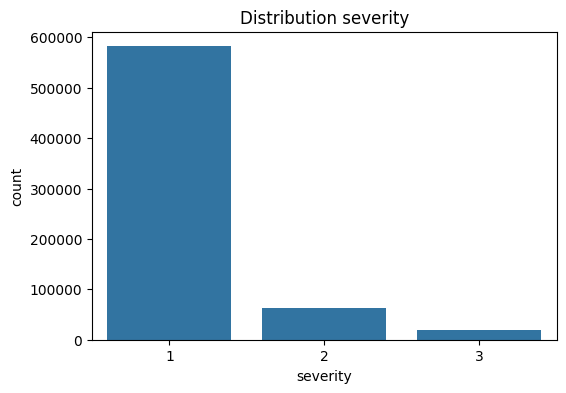

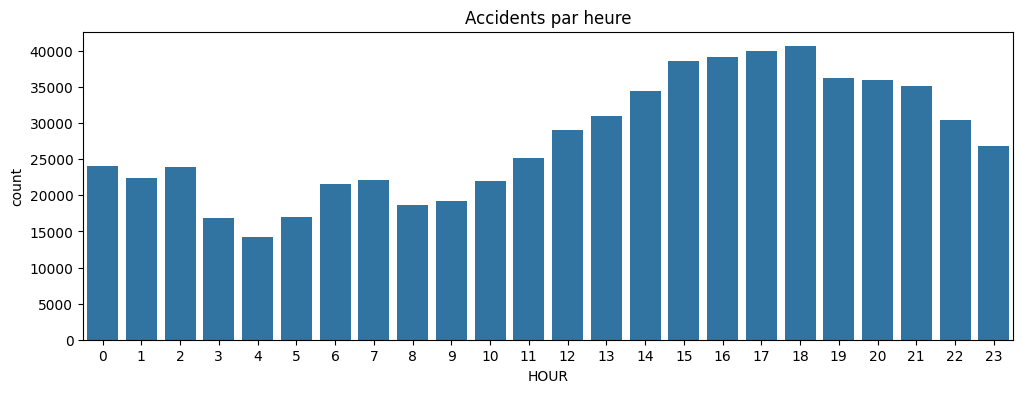

severity,1,2,3
LIGHT_COND,,,
day,0.87864,0.093089,0.028270
night,0.87192,0.097334,0.030745


In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='severity', data=df)
plt.title("Distribution severity")
plt.show()

plt.figure(figsize=(12,4))
sns.countplot(x='HOUR', data=df, order=sorted(df['HOUR'].dropna().unique()))
plt.title("Accidents par heure")
plt.show()

# severity by day/night
pd.crosstab(df['LIGHT_COND'], df['severity'], normalize='index')


### severity vs météo (boxplots / violin)

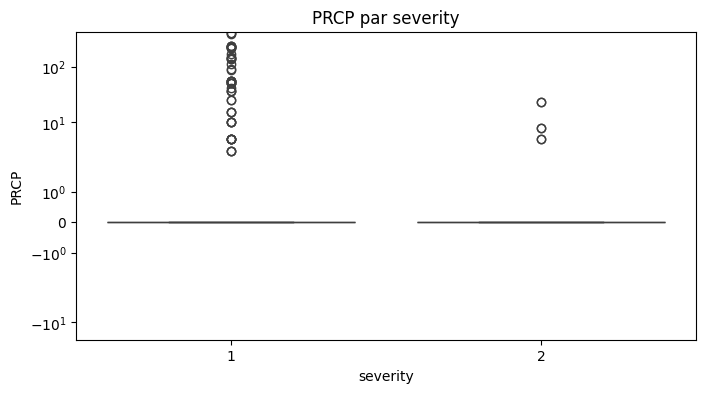

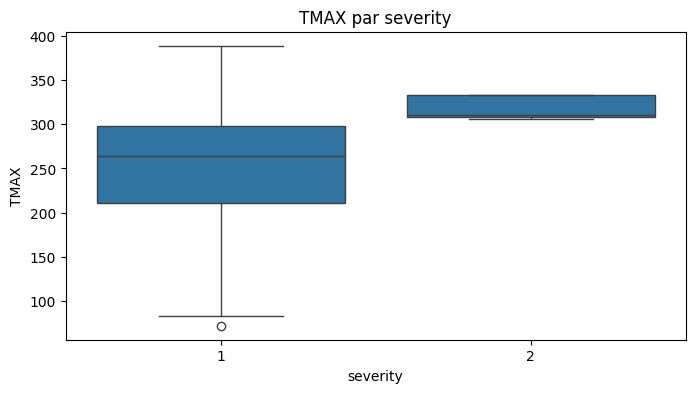

In [6]:
plt.figure(figsize=(8,4))
sns.boxplot(x='severity', y='PRCP', data=df[df['PRCP'].notna()])
plt.yscale('symlog')  # utile si beaucoup de zéros
plt.title("PRCP par severity")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='severity', y='TMAX', data=df[df['TMAX'].notna()])
plt.title("TMAX par severity")
plt.show()


### Corrélation numérique

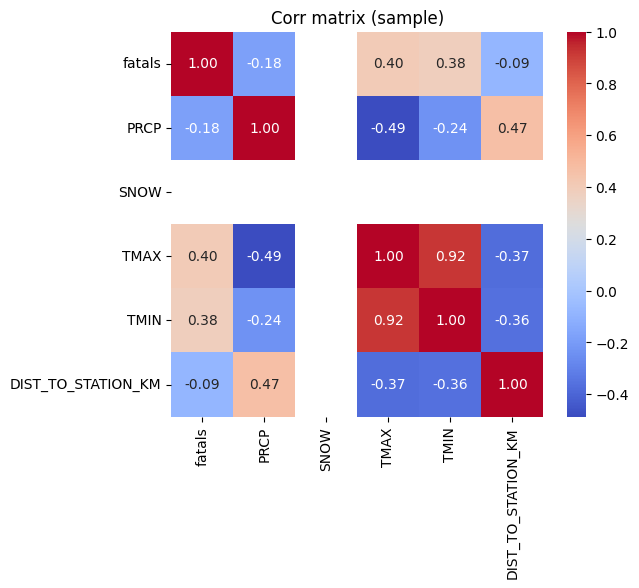

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélection des colonnes et suppression des NaN
num = df[['fatals','PRCP','SNOW','TMAX','TMIN','DIST_TO_STATION_KM']].dropna()

# Échantillonnage sûr
num = num.sample(n=min(200000, len(num)), random_state=42)

# Matrice de corrélation
corr = num.corr()

# Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Corr matrix (sample)")
plt.show()


### Préparation ML minimal (features + split)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_parquet("data/gold/GOLD_FEATURES.parquet")

# features candidates 
features = [
  'HOUR', 'LIGHT_COND', 'ROUTE_TYPE', 'VEHICLE_TYPE',
  'COLLISION_TYPE', 'AREA_TYPE', 'PRCP','SNOW','TMAX','TMIN','DIST_TO_STATION_KM'
]

# simple encoding: one-hot for categorical, fillna
X = df[features].copy()
X['HOUR'] = X['HOUR'].fillna(-1)
X['DIST_TO_STATION_KM'] = X['DIST_TO_STATION_KM'].fillna(9999)
X['PRCP'] = X['PRCP'].fillna(0)
X['SNOW'] = X['SNOW'].fillna(0)
X['TMAX'] = X['TMAX'].fillna(X['TMAX'].median())
X['TMIN'] = X['TMIN'].fillna(X['TMIN'].median())

# one-hot
X = pd.get_dummies(X, columns=['LIGHT_COND','ROUTE_TYPE','VEHICLE_TYPE','COLLISION_TYPE','AREA_TYPE'], dummy_na=True)

y = df['severity']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train/Test sizes:", X_train.shape, X_test.shape)
# save for later
X_train.to_parquet("data/silver/ml_X_train.parquet")
X_test.to_parquet("data/silver/ml_X_test.parquet")

y_train.to_frame().to_parquet("data/silver/ml_y_train.parquet")
y_test.to_frame().to_parquet("data/silver/ml_y_test.parquet")



C:\Users\oumis\AppData\Local\Temp\ipykernel_13928\574552303.py:22: FutureWarning: The behavior of Index.insert with object-dtype is deprecated, in a future version this will return an object-dtype Index instead of inferring a non-object dtype. To retain the old behavior, do `idx.insert(loc, item).infer_objects(copy=False)`
  X = pd.get_dummies(X, columns=['LIGHT_COND','ROUTE_TYPE','VEHICLE_TYPE','COLLISION_TYPE','AREA_TYPE'], dummy_na=True)


Train/Test sizes: (531621, 31) (132906, 31)


### Baseline — RandomForest

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os

# créer le dossier models
os.makedirs("models", exist_ok=True)

# charger les données
X_train = pd.read_parquet("data/silver/ml_X_train.parquet")
X_test  = pd.read_parquet("data/silver/ml_X_test.parquet")
y_train = pd.read_parquet("data/silver/ml_y_train.parquet").squeeze()
y_test  = pd.read_parquet("data/silver/ml_y_test.parquet").squeeze()

# créer et entraîner le modèle
clf = RandomForestClassifier(
    n_estimators=200,
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

# prédictions et évaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# sauvegarder le modèle
joblib.dump(clf, "models/rf_baseline.joblib")


              precision    recall  f1-score   support

           1       0.98      0.97      0.97    116396
           2       0.77      0.84      0.80     12613
           3       0.85      0.92      0.88      3897

    accuracy                           0.95    132906
   macro avg       0.86      0.91      0.89    132906
weighted avg       0.96      0.95      0.95    132906

[[112585   3202    609]
 [  1991  10576     46]
 [   271     25   3601]]


['models/rf_baseline.joblib']

### XGBOOST

In [12]:
from xgboost import XGBClassifier

# charger les données
X_train = pd.read_parquet("data/silver/ml_X_train.parquet")
X_test  = pd.read_parquet("data/silver/ml_X_test.parquet")
y_train = pd.read_parquet("data/silver/ml_y_train.parquet").squeeze()
y_test  = pd.read_parquet("data/silver/ml_y_test.parquet").squeeze()

# recalage des labels pour XGBoost (ils doivent commencer à 0)
y_train = y_train - 1
y_test  = y_test - 1

# initialiser le modèle XGBoost
clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',  # pour multi-classes
    random_state=42
)

# entraîner le modèle
clf.fit(X_train, y_train)

# prédictions
y_pred = clf.predict(X_test)

# affichage des métriques avec labels originaux
print(classification_report(y_test + 1, y_pred + 1))
print(confusion_matrix(y_test + 1, y_pred + 1))

# sauvegarder le modèle
joblib.dump(clf, "models/xgb_baseline.joblib")


c:\Users\oumis\Desktop\accidents_bigdata\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:46:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           1       0.88      1.00      0.93    116396
           2       0.88      0.01      0.02     12613
           3       0.94      0.05      0.09      3897

    accuracy                           0.88    132906
   macro avg       0.90      0.35      0.35    132906
weighted avg       0.88      0.88      0.82    132906

[[116377     10      9]
 [ 12511    100      2]
 [  3716      3    178]]


['models/xgb_baseline.joblib']

### Interprétabilité — SHAP

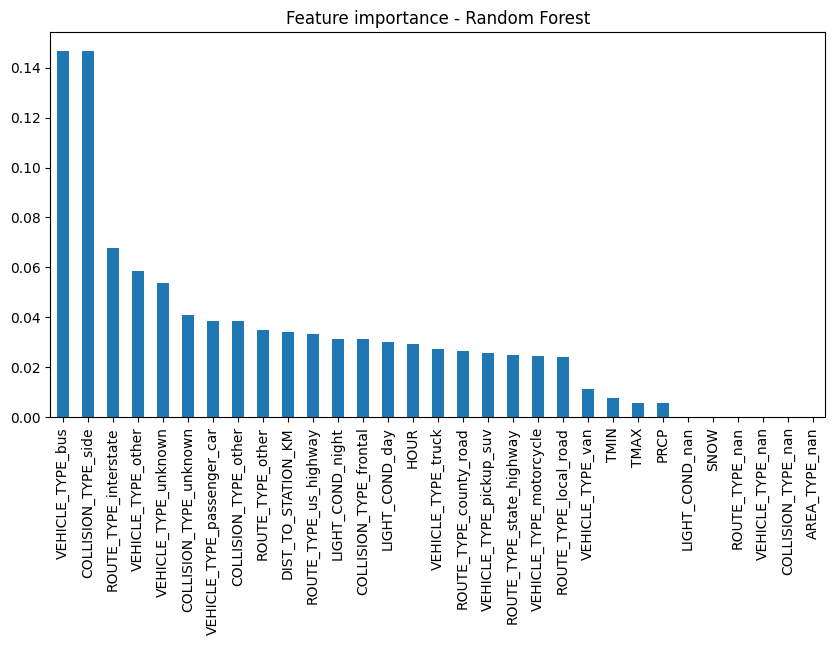

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

importances = clf.feature_importances_
feat_names = X_test.columns

pd.Series(importances, index=feat_names).sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Feature importance - Random Forest")
plt.show()
